# **Personalized Fashion Recommender System**

**Tianxin Zhang(tz2483), Yujin Lee(yl9709),  Zehui Ye(zy2654)**

## **Part I: Introduction**

Fashion is a highly personal and subjective domain, where people often have their own unique sense of style and preferences. With the rise of e-commerce and online shopping, there has been an increasing demand for personalized fashion recommendations that cater to individual tastes and needs. 

Using a large dataset containing contemporary clothing images that are available online, we built a personalized fashion recommender system that provides tailored recommendations based on users' preferences. We use popular deep learning model called ResNet to extract embeddings from the images. Then, we use Spotify's Approximate Nearest Neighbor Oh Yeah (ANNOY) and vectorized cosine distance to find similar images. 

Details on the ANNOY library can be found [here](https://github.com/spotify/annoy/blob/main/README.rst).


##  **Process**
**Data:**
- We retrieved a well categorized large dataset containing contemporary clothing images created and open-sourced by the Multimedia Laboratory at the Chinese University of Hong Kong. The data consists of 289,222 images of clothes across 50 categories with 1,000 attributes. 
The data can be obtained [here](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html). 


**Data Processing**
- The images are first converted to fastAI's DataBunch objects through fast.ai's ImageList fucntion, which helps us efficiently load the images and provides various methods to manipulate and transform the images before feeding them into a CNN model. Details on the image transformation is described in the pre-processing section of this notebook. 

**Model**
- The images are then fed into convolutional neural network (CNN) models, which allow us to extract embeddings. Embeddings that CNNs produce are condensed represenation of images that encodes their visual characteristics. Images are reduced to vectors of numerical values that capture their shape, pattern, and other visual contents.  

- To obtain the embeddings, we used Resnet18 and Resnet50, that were already trained for image classification. The process is called transfer learning, where we take advantage of the models that have already learned to recognize many features of the data. The end layer of a CNN, which is a fully connected linear layer, is used as image embeddings. 

- While we used CNNs that were pre-trained, we still trained the last few layers of the model using our data to fine-tune them and then extracted the embeddings. 


**Distance Metric**
-  To find similar images, we used Spotify's ANNOY algorithm as well as cosine distance.
  - ANNOY is an algorithm based on random projections and trees that computes the nearest neighbors by splitting the set of points into half and doing it recursively until it reaches k times. Based on the tradeoff we get between accuracy and build time, we chose to build 200 trees.

**Simulation**

- A fictional user's preference was generated manually. Our team member created a persona and her fashion preferences. We then obtained recommended outfits based on the selection. 

- We are going to evaluate the result based on the output images and to see whether we really like the recommendations it provides.

## **Part II: Data Pre-processing**

In this part, we pre-processing on our image data, carry out exploratory data analysis, and transform them into embeddings. 

### **A. Setup**

In [4]:
!pip3 install annoy
!pip3 install gdown
!pip install fastai==1.0.61
# !pip install torch==1.4.0
# !pip install torchvision==0.5.0
!pip3 install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import matplotlib
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from fastai.vision import *
from annoy import AnnoyIndex
import time
import gdown as gdown
%matplotlib inline

### **B. Geting Data**

First, we retrieve the text data associated with the images we will use as inputs. 

(1) 'list_category_cloth.txt' lists out each clothing category name, such as hoodie and jacket, and a number corresponding to its category type ("1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes).

(2) 'list_category_img.txt' lists out image name (file name) and category label, which represents a category ID for each category name in 'list_category_cloth.txt'. 

(3) 'list_eval_partition.txt' classifies each image into "train","val", or test" category. (More detail to be added on how they are split)

In [6]:
# retrieve the text data
url = 'https://drive.google.com/uc?id=1TUCQJsMKGY_bAWH2Kj5-rZlzxqJ67H3n&export=download'
output = 'list_category_cloth.txt'
gdown.download(url, output)

url = 'https://drive.google.com/uc?id=1K5qogDsrlMTNQPiNqfDnyE08EXRUP13b&export=download'
output = 'list_category_img.txt'
gdown.download(url, output)

url = 'https://drive.google.com/uc?id=1ypad2tt635tRZ9CMARcNztoFc6tFXPMW&export=download'
output = 'list_eval_partition.txt'
gdown.download(url, output)


Downloading...
From: https://drive.google.com/uc?id=1TUCQJsMKGY_bAWH2Kj5-rZlzxqJ67H3n&export=download
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 3.63MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K5qogDsrlMTNQPiNqfDnyE08EXRUP13b&export=download
To: /content/list_category_img.txt
100%|██████████| 21.4M/21.4M [00:00<00:00, 192MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ypad2tt635tRZ9CMARcNztoFc6tFXPMW&export=download
To: /content/list_eval_partition.txt
100%|██████████| 22.2M/22.2M [00:00<00:00, 174MB/s]


'list_eval_partition.txt'

In [7]:
# retrieve image data
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
100%|██████████| 2.68G/2.68G [00:30<00:00, 89.3MB/s]


In [8]:
# saving each text file into a list

category_list = [] # 'list_category_cloth.txt'
image_path_list = [] # 'list_category_img.txt'
data_type_list = [] # 'list_eval_partition.txt'
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category im
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [9]:
# displaying the shape of each list

print(f'Shape of category_list: {len(category_list)}')
print(f'Shape of  image_path_list: {len(image_path_list)}')
print(f'Shape of  data_type_list: {len(data_type_list)}')

Shape of category_list: 50
Shape of  image_path_list: 289222
Shape of  data_type_list: 289222


In [ ]:
# displaying 'list_category_cloth.txt'

category_list[:5]

['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down']

In [ ]:
# displaying 'list_category_img.txt'

temp = pd.DataFrame(image_path_list, columns =['image_id', 'category_id'])
temp.head()

image_id category_id
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg           3
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg           3
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg           3
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg           3
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg           3

In [ ]:
# displaying 'list_eval_partition.txt'

temp =pd.DataFrame(data_type_list, columns =['image_id', 'dataset_type'])
temp.head()

image_id dataset_type
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg        train
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg        train
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg          val
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg        train
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg         test

In [10]:
clothes_ls = ['upper-body', 'lower-body', 'full-body']
dict(zip([1,2,3], clothes_ls))

{1: 'upper-body', 2: 'lower-body', 3: 'full-body'}

In [11]:
# creating a temporary dataset containing 'category_type_label' before merging it into a single dataframe

category_type_list = []

with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

temp = pd.DataFrame(category_type_list, columns =['category', 'category_type'])
temp['category_type'] = temp['category_type'].astype(int)
temp['category_type_label'] = temp['category_type'].map(dict(zip([1,2,3], clothes_ls)))
temp.head()

category  category_type category_type_label
0       Anorak              1          upper-body
1       Blazer              1          upper-body
2       Blouse              1          upper-body
3       Bomber              1          upper-body
4  Button-Down              1          upper-body

In [12]:
# merging the text files into a single dataframe

meta_df = pd.DataFrame(image_path_list, columns = ['image_id', 'category_id'])
meta_df['category_id'] = meta_df['category_id'].astype(int)
meta_df['category'] = meta_df['category_id'].apply(lambda x: category_list[x-1])
meta_df = meta_df.merge(pd.DataFrame(data_type_list, columns = ['image_id', 'dataset_type']), on = 'image_id')
meta_df = meta_df.merge(temp, on = 'category') 
meta_df.drop('category_type', axis=1, inplace = True)
meta_df.drop('category_id', axis=1, inplace = True)
meta_df.head()

image_id category dataset_type  \
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   Blouse        train   
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   Blouse        train   
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   Blouse          val   
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   Blouse        train   
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   Blouse         test   

  category_type_label  
0          upper-body  
1          upper-body  
2          upper-body  
3          upper-body  
4          upper-body

In [14]:
# Out of 289222 images
# 72% will be in the training set, 
# 14% will be in the testing set, and
# 14% will be in the validation set.

meta_df[['image_id', 'dataset_type']].groupby('dataset_type').count()

image_id
dataset_type          
test             40000
train           209222
val              40000

In [ ]:
# Calculates the number of images per each category
category_num = meta_df[['image_id','category']].groupby('category').count().reset_index()
category_num["Percentage"] = category_num['image_id']/category_num['image_id'].sum()
category_num.head()

category  image_id  Percentage
0       Anorak       160    0.000553
1       Blazer      7495    0.025914
2       Blouse     24557    0.084907
3       Bomber       309    0.001068
4  Button-Down       330    0.001141

###**C. Distribution of images in each clothing category**


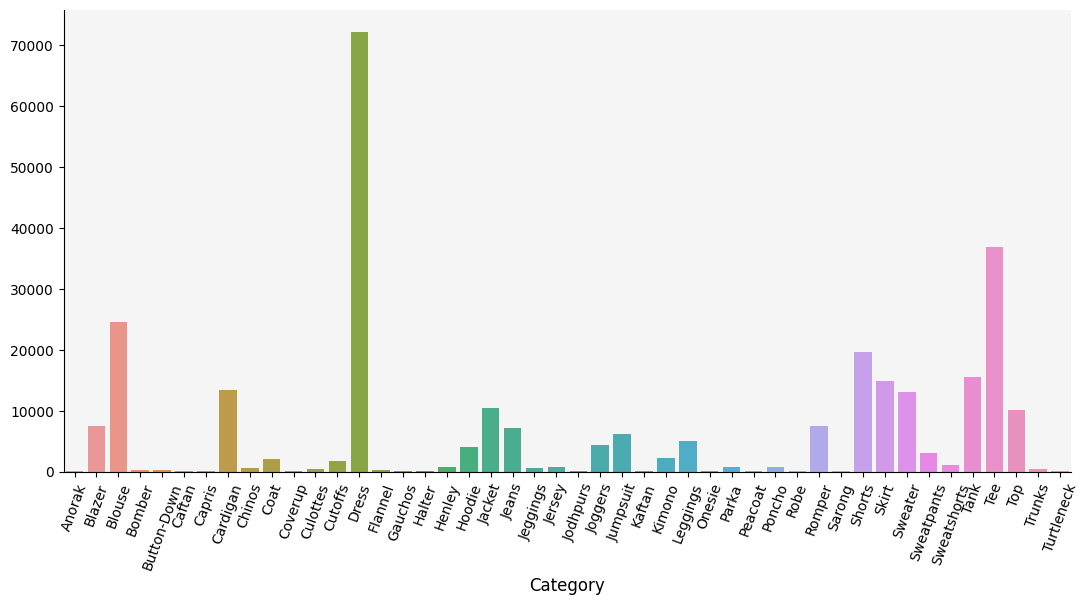

In [ ]:
# Plotting the histogram of images in clothing category

fig, ax = plt.subplots(figsize = (13, 6))

ax.set_facecolor('whitesmoke')
sns.set_context('paper')
sns.barplot(category_num, x='category', y='image_id')
ax.set_xticklabels(category_num['category'], rotation = 70)
ax.set(ylabel=None)
ax.set_xlabel('Category', fontdict = {'fontsize': 12, 'fontweight': 'book'})
sns.despine()


plt.show()

Among the image dataset, "Dress" is the most frequently occurring category with over 70,000 images, accounting for 25% of the total dataset. Dresses are overrepresented in our dataset, as the category encompasses a wide range of clothes, such as capes, pajama dresses, shirt dresses and sundresses. 

Conversely, 28 categories, including "Anorak", "Bomber", "Button-Down", "Caftan", "Capris", among others, have less than 1% representation in the dataset, indicating a significantly smaller number of images.

In [ ]:
clothes_num = meta_df[['image_id','category_type_label']].groupby('category_type_label').count().reset_index()
clothes_num["Percentage"] = clothes_num['image_id']/clothes_num['image_id'].sum()
clothes_num

category_type_label  image_id  Percentage
0           full-body     90550    0.313081
1          lower-body     58963    0.203868
2          upper-body    139709    0.483051

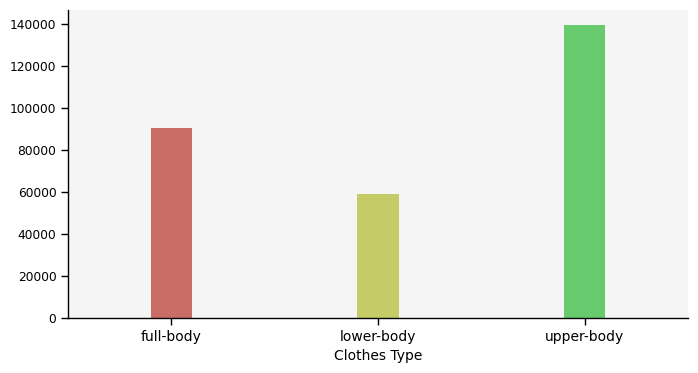

In [ ]:
# Plotting the histogram of images in each category type label (full body, lower body, upper body)

fig, ax = plt.subplots(figsize = (8,4))

ax.set_facecolor('whitesmoke')
sns.set_context('paper')
sns.set_palette('hls')
sns.barplot(clothes_num, x = 'category_type_label', y = 'image_id', width = 0.2)
ax.set_xticklabels(clothes_num['category_type_label'], fontsize = 10)
ax.set(ylabel=None)
ax.set_xlabel('Clothes Type', fontdict = {'fontsize': 10, 'fontweight': 'book'})
sns.despine()

plt.show()

Within our image dataset, "upper-body" clothing has the highest number of categories, representing nearly half of the dataset (48%). Conversely, "lower-body" clothing has the least number of categories, accounting for only 20%.

###**D. Load and Pre-process Images**

We use FastAI's ImageDataLoader to convert images along with their labels and transform them into a batch-wise iterable that can be fed into a CNN for training. The output of this process are two tensors - one containing the input image and another containing their corresponding label - for each training and test dataset. We apply a set of image transformation such as resizing and normalization. 

In [15]:
import fastai
import torch
torch.cuda.is_available()

True

In [16]:
def train_val_test_split(df):
    
    train = df.query(" dataset_type == 'train' " )
    val = df.query(" dataset_type == 'val' " )
    test = df.query(" dataset_type == 'test' " )
    return train, val, test

In [17]:
 meta_train, meta_val, meta_test = train_val_test_split(meta_df)

In [18]:
# Loading and processing images using ImageDataLoader

train_image_list = ImageList.from_df(df = meta_df, path='', cols='image_id').split_by_idxs(
    (meta_df[meta_df['dataset_type']=='train'].index),
    (meta_df[meta_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=meta_df[meta_df['dataset_type'] == 'test'], path='', cols='image_id')

In [19]:
train_image_list = train_image_list.transform(size=224)
data = train_image_list.databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)

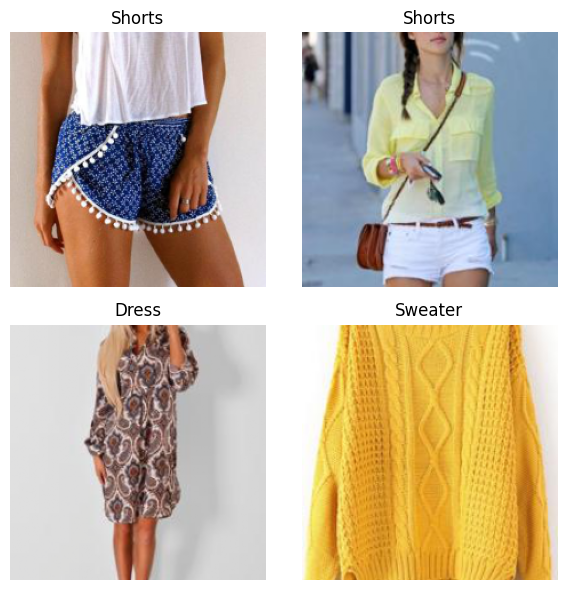

In [ ]:
data.show_batch(rows=2, figsize = (6,6))

### **E. Extract embeddings using Pre-trained Resnet18**

We use a pre-trained CNN to extract embeddings from our images. 

In the next part part, we use ResNet18, which is a widely-used pre-trained CNN that has been shown to achieve a good performance on image classification tasks. 

There are other pre-trained CNNs such as ResNet50, which is a deeper version of ResNet18, and EfficientNet, which was developed by Google and has been shown to achieve better accuracy. 

In the second part, we use ResNet50 to perform the same procedure and compare the result with the one obtained using ResNet50.

In [20]:
from fastai.metrics import accuracy, top_k_accuracy
top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)

#### (1) Conduct Transfer Learning Using ResNet18


In [ ]:
learner = cnn_learner(data, models.resnet18, pretrained=True, metrics=[accuracy, top_3_accuracy, top_5_accuracy])
learner.model = torch.nn.DataParallel(learner.model) # enables multi GPU training


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 306MB/s]


In [ ]:
# learner.lr_find() # This takes a very long time. Do not re-run. The suggested learning rate was obtained below. 
# SuggestedLRs(valley=0.001737800776027143)


In [ ]:
# Fitting the model
learner.fit_one_cycle(10, max_lr=1e-03)



The model achieved top 3 accuracy of 84.4% and top 5 accuracy of 91.4%. 

In [ ]:
final_layer = learner.model.module[-1][-1]
print(f'Final Layer after transfer learning: {final_layer}')

Final Layer after transfer learning: Linear(in_features=512, out_features=46, bias=True)


To do transfer learning using Resnet50, we reserve all the previous layers and parameters but replace the output layer with 41 neurons. (The number of categories). Then we further trained the model to make it work well on our data set.

In [ ]:
learner.save('resnet18_05_19')

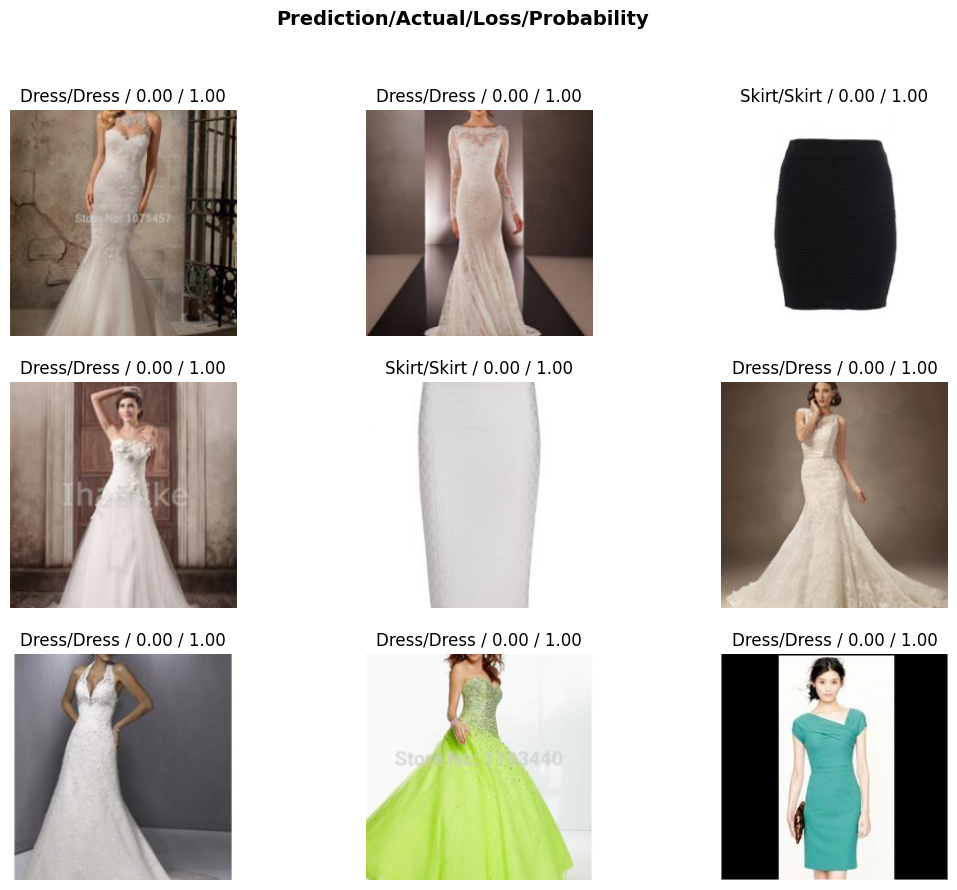

In [ ]:
# Plotting the first 9 smallest losses 
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(13,10), heatmap_thresh=5)

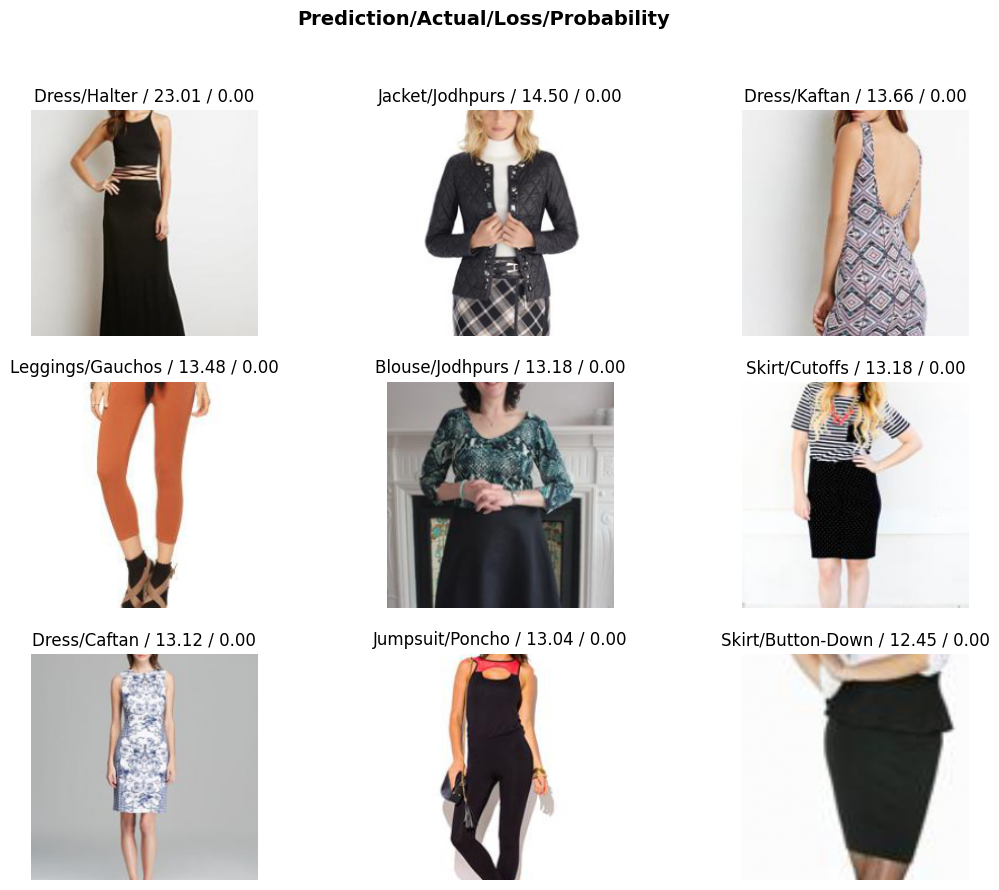

In [ ]:
# Plotting the first 9 biggest losses 


interp.plot_top_losses(9, largest=True, figsize=(13,10), heatmap_thresh=5)

As we can see above, the ones with the biggest losses are bad predictions that can be improved with further training.

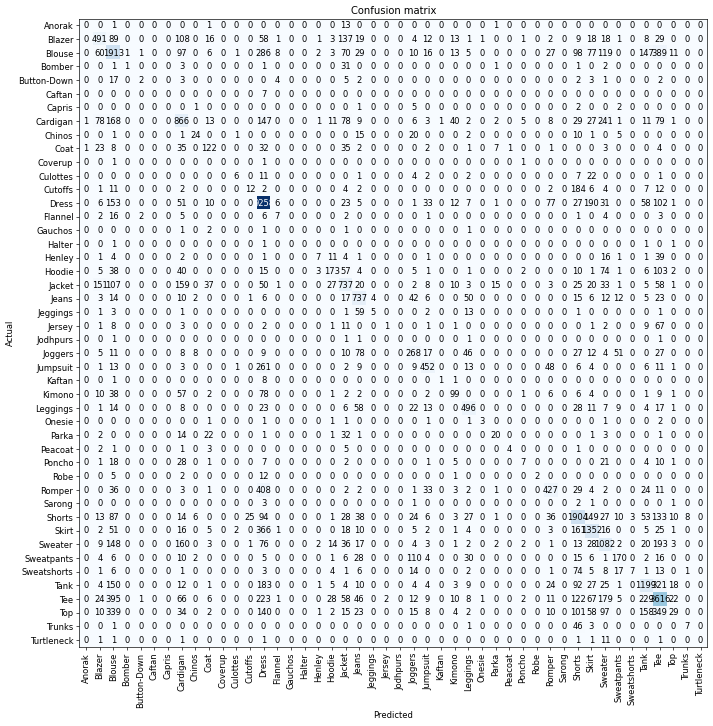

In [ ]:
# Plotting a confusion matrix to see the performance of CNN. 
interp.plot_confusion_matrix(figsize = (12,12), dpi=60)

In [ ]:
learner.model # model details

DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
learner.save('/content/gdrive/My Drive/resnet18-fashion')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model = learner.model.module

#### (2) Conduct Transfer Learning Using ResNet50


In [ ]:
learner2 = cnn_learner(data, models.resnet50, pretrained=True, metrics=[accuracy, top_3_accuracy, top_5_accuracy])
# Enable multi-GPU training
learner2.model = torch.nn.DataParallel(learner2.model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 245MB/s]


In [ ]:
# Do not re-run! The model was already run and is saved in the drive. 
learner2.fit_one_cycle(10, max_lr=1e-03)


The model achieved top 3 accuracy of 87.31% and top 5 accuracy of 93.17%. 

In [ ]:
final_layer2 = learner2.model.module[-1][-1]
print(f'Final Layer after transfer learning: {final_layer2}')

Final Layer after transfer learning: Linear(in_features=512, out_features=46, bias=True)


To do transfer learning using Resnet50, we reserve all the previous layers and parameters but replace the output layer with 41 neurons. (The number of categories). Then we further trained the model to make it work well on our data set.

In [ ]:
from google.colab import drive
learner2.save('resnet50_05_20')
drive.mount('/content/gdrive')
learner2.save('/content/gdrive/My Drive/resnet50-fashion')

Mounted at /content/gdrive


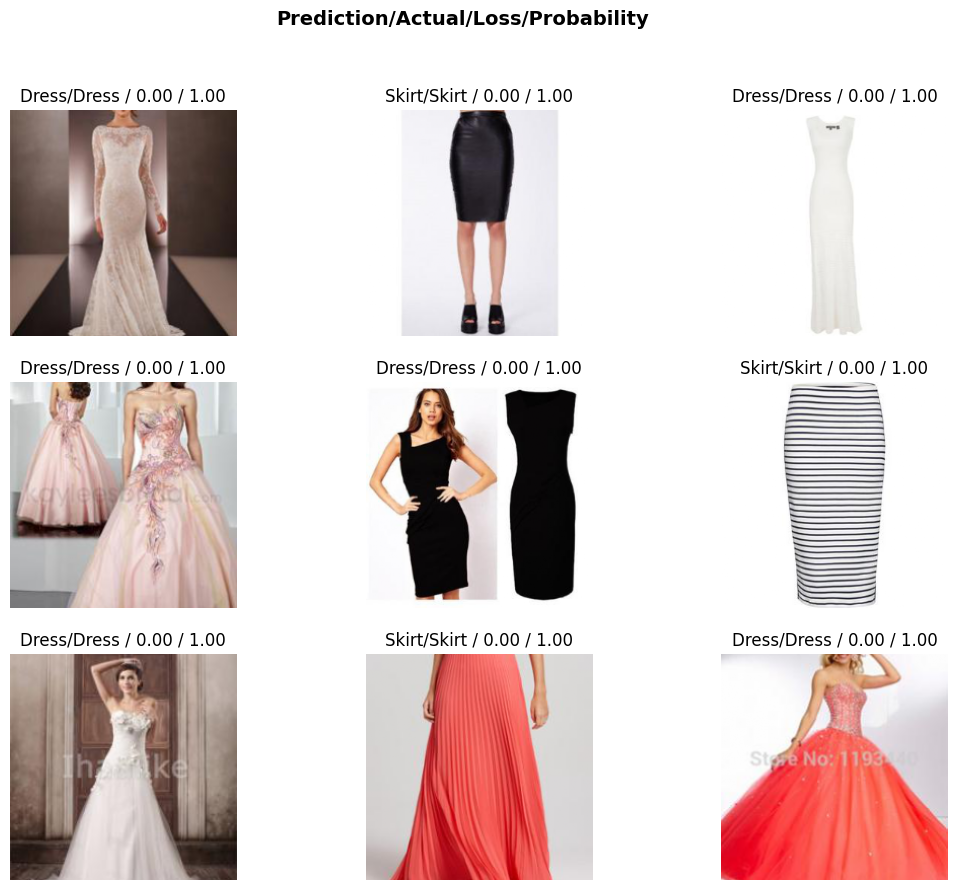

In [ ]:
# preds,y,losses = learner.get_preds(with_loss=True)  # obtain prediction 
# interp = ClassificationInterpretation(learner, train_image_list, losses)
interp2 = ClassificationInterpretation.from_learner(learner2)
interp2.plot_top_losses(9, largest=False, figsize=(13,10), heatmap_thresh=5)

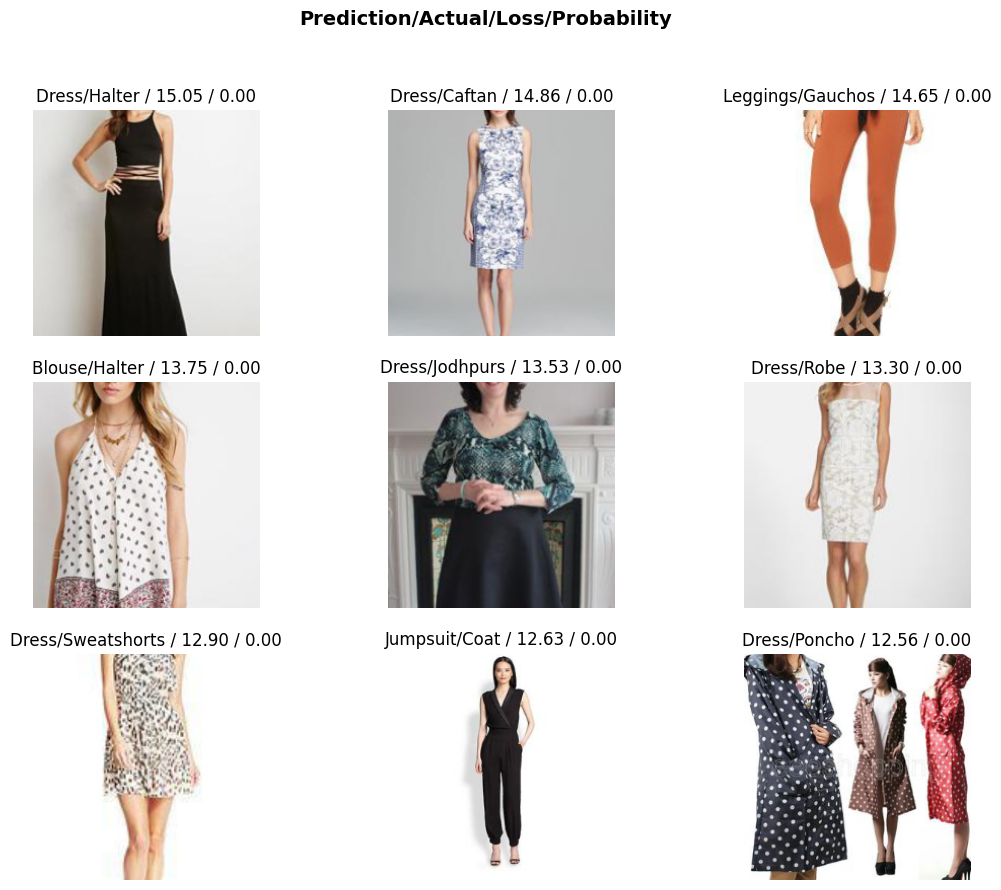

In [ ]:
interp2.plot_top_losses(9, largest=True, figsize=(13,10), heatmap_thresh=5)

Compared to the ResNet18 results, the ones with the biggest losses are not all bad predictions as some of the images themselves can understandably classified into wrong category by human, such as Dress/Poncho.

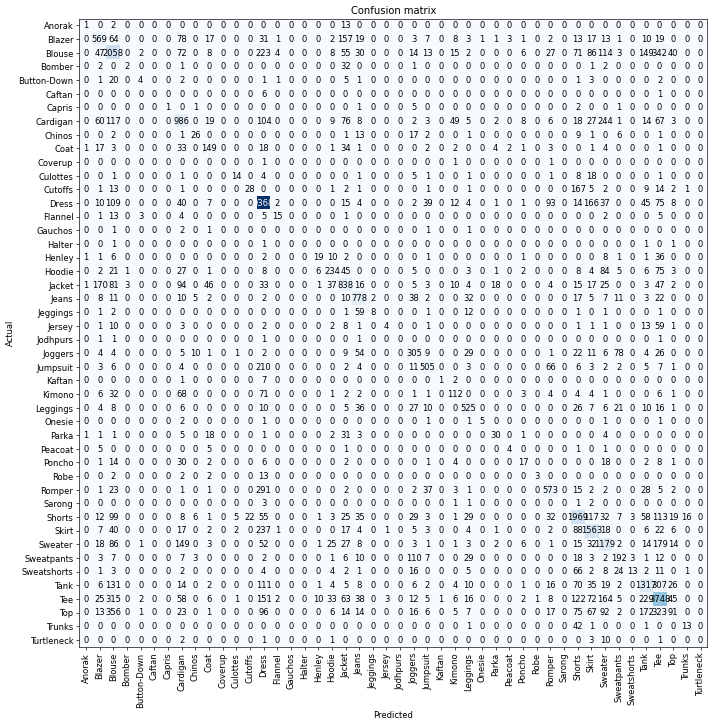

In [ ]:
interp2.plot_confusion_matrix(figsize = (12,12), dpi=60)

In [ ]:
model2 = learner2.model.module

#### (3) Extract Embedding from the trained ResNet18 using fast.ai hook

In [21]:
# creating a function extracting embeddings
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [22]:
# creating a function to load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

In [23]:
# load the trained model

pretrained_model = models.resnet18
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
model_path = "/content/gdrive/My Drive/resnet18-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


In [24]:
# specify the embedding layer, which is the one before the output layer. 

embedding_layer = learner.model.module[1][4]
print(f'Embedding Layer: {embedding_layer}')

Embedding Layer: Linear(in_features=1024, out_features=512, bias=True)


In [ ]:
# retrieve the embeddings from the layer above

saved_features = SaveFeatures(embedding_layer)
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
# retrieve the embeddings from the layer above

saved_features = SaveFeatures(embedding_layer)
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
# populate the embeddings with image path, label, and label id

img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_output = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_output['embeddings'] = np.array(saved_features.features).tolist()
data_df_output

img_path   label  label_id  \
0       ./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  Blouse         2   
1       ./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  Blouse         2   
2       ./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  Blouse         2   
3       ./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg  Blouse         2   
4       ./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg  Blouse         2   
...                                                   ...     ...       ...   
249217    ./img/Panda-Hood_Pajama_Onesie/img_00000045.jpg  Onesie        29   
249218    ./img/Panda-Hood_Pajama_Onesie/img_00000051.jpg  Onesie        29   
249219    ./img/Panda-Hood_Pajama_Onesie/img_00000065.jpg  Onesie        29   
249220    ./img/Panda-Hood_Pajama_Onesie/img_00000066.jpg  Onesie        29   
249221    ./img/Panda-Hood_Pajama_Onesie/img_00000068.jpg  Onesie        29   

                                               embeddings  
0       [-3.6719233989715576, -8.105217933654785, 3.09...  
1       [-7.255760669708252, -2.6237807273864746, -6.9...  
2       [-1.6900583505630493, -10.312360763549805, -1....  
3       [-0.08677425980567932, -8.683576583862305, 0.9...  
4       [-6.630371570587158, -10.393746376037598, -2.2...  
...                                                   ...  
249217  [3.700277090072632, -4.421217918395996, -8.983...  
249218  [-6.493416786193848, -1.491929531097412, -2.77...  
249219  [-0.7021535038948059, -11.923385620117188, -1....  
249220  [-0.08435726165771484, -11.143586158752441, 4....  
249221  [-2.0941762924194336, 5.080271244049072, -2.56...  

[249222 rows x 4 columns]

#### (4) Extract Embeddings from the trained ResNet50 using fast.ai hook

The following codes use the same process above to extract the embeddings from the trained ResNet50 model. 

In [26]:
# load the trained model

pretrained_model = models.resnet50
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
model_path = "/content/gdrive/My Drive/resnet50-fashion"
learner2 = load_learner(data, pretrained_model, model_metrics, model_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# specify the embedding layer, which is the one before the output layer. 

embedding_layer = learner2.model.module[1][4]
print(f'Embedding Layer: {embedding_layer}')


Embedding Layer: Linear(in_features=4096, out_features=512, bias=True)


In [28]:
# retrieve the embeddings from the layer above

saved_features = SaveFeatures(embedding_layer)
_= learner2.get_preds(data.train_ds)
_= learner2.get_preds(DatasetType.Valid)

In [29]:
# populate the embeddings with image path, label, and label id

img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_output2 = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_output2['embeddings'] = np.array(saved_features.features).tolist()
data_df_output2

img_path   label  label_id  \
0       ./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  Blouse         2   
1       ./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  Blouse         2   
2       ./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  Blouse         2   
3       ./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg  Blouse         2   
4       ./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg  Blouse         2   
...                                                   ...     ...       ...   
249217    ./img/Panda-Hood_Pajama_Onesie/img_00000045.jpg  Onesie        29   
249218    ./img/Panda-Hood_Pajama_Onesie/img_00000051.jpg  Onesie        29   
249219    ./img/Panda-Hood_Pajama_Onesie/img_00000065.jpg  Onesie        29   
249220    ./img/Panda-Hood_Pajama_Onesie/img_00000066.jpg  Onesie        29   
249221    ./img/Panda-Hood_Pajama_Onesie/img_00000068.jpg  Onesie        29   

                                               embeddings  
0       [13.029820442199707, -1.1166629791259766, -23....  
1       [-5.314202308654785, -20.44700813293457, -24.1...  
2       [-10.165027618408203, 3.994637966156006, 0.441...  
3       [10.041221618652344, 10.52851390838623, -13.07...  
4       [12.638750076293945, 13.14390754699707, 10.336...  
...                                                   ...  
249217  [11.420283317565918, 12.67674732208252, 27.186...  
249218  [8.99885082244873, 11.25598430633545, -7.09676...  
249219  [-25.34638786315918, 21.171485900878906, 31.11...  
249220  [-6.871705532073975, 8.404315948486328, 28.044...  
249221  [12.078193664550781, -1.716325044631958, 1.414...  

[249222 rows x 4 columns]

## Part III: Get Similar Images

In Part three of our project, we create functions to generate similar images using the ANNOY and cosine distance 

To demonstrate the results, we selected a few images of dresses from the dataset and applied both methods to find similar images. We will present the obtained results to evaluate the effectiveness and efficiency of these two approaches in generating similar images.

This part is organized as follows:

(A) Using ResNet18 Embeddings
 1. Generate Similar Images Using ANNOY
 2. Generate Similar Images Using Cosine Distance

(B) Using ResNet50 Embeddings
 1. Generate Similar Images Using ANNOY
 2. Generate Similar Images Using Cosine Distance

### **A. Using ResNet18 Embeddings**

#### (1) Generate Similar Images Using ANNOY

In [32]:
# def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
#     start = time.time()
#     img_id, img_label  = data_df_output.iloc[img_index, [0, 1]]
#     similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
#     end = time.time()
#     print(f'{(end - start) * 1000} ms')
#     return img_id, img_label, data_df_output.iloc[similar_img_ids[1:]] # ignores the first image as it is the same as the inputted image. 


# creating a function to get similar images using ANNOY tree 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return data_df_output.iloc[similar_img_ids[1:]] # ignores the first image as it is the same as the inputted image. 

# creating a function to display similar images
def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [33]:
from annoy import AnnoyIndex
ntree = 200
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_output['embeddings'][0]), metric=metric_choice)

for i, vector in enumerate(data_df_output['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

In [34]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

In [ ]:
# Select random dresses

outfit_img_ids = [143716, 143717, 143718, 143719]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_output.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_output.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

2.6803016662597656 ms


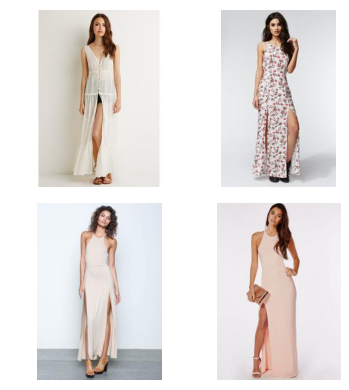

In [ ]:
# display the selected images

show_similar_images(outfits_selected, fig_size=[4,4])

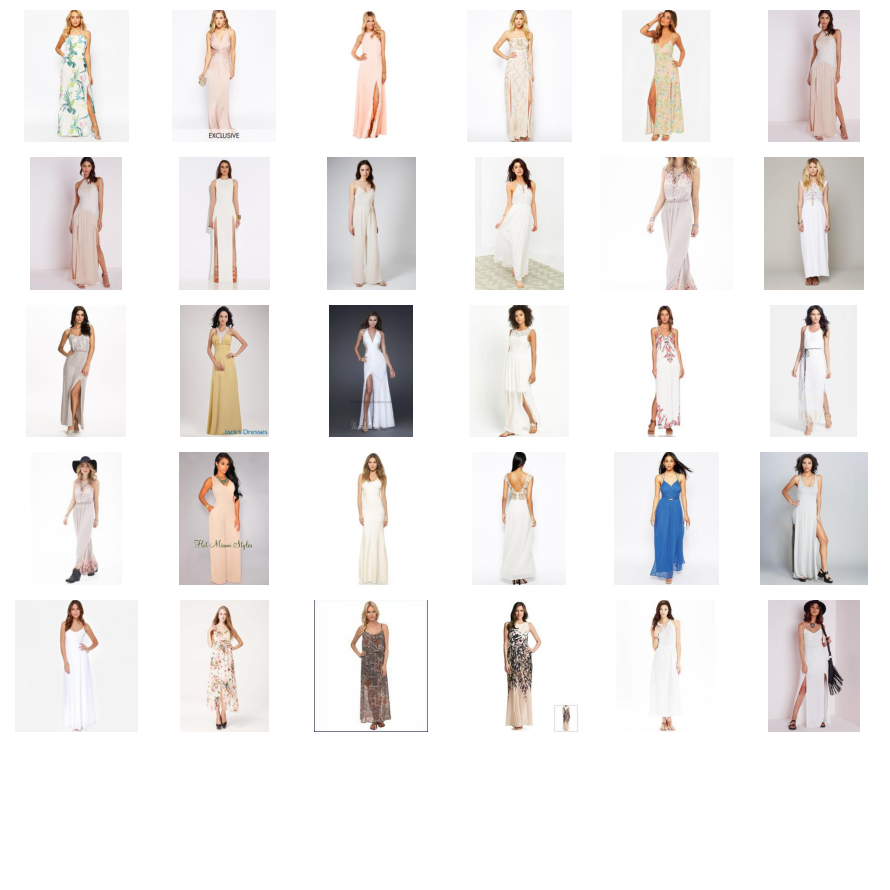

In [ ]:
# display similar images

show_similar_images(similar_images_df, fig_size=[9,9])

The recommender system using the ANNOY algorithm generated images that are either very similar to or close enough to the target images but have different pattern and/or colors. 

The result is very good, because the recommended products all seem to be items for similar occasions (like summer wedding parties) but there are surprising variations that are also appealing. The recommended dresses all have the same length and are all sleeveless, and are generally light colored, which are consistent with the input. The blue dress is clearly an outlier due to its color, which is a good surprise for the consumer, but otherwise it is very similar to other images. We can also see that the model recommended patterns other than the flower pattern from the second input image. These variations would allow consumers to consider buying other items even though they do not look exactly like the ones they were initially looking to purchase.

#### (2) Generate Similar Images Cosine Distance

In [ ]:
from scipy.spatial.distance import cosine

def get_similar_images_cos(img_index, n=10):
    base_img_id, base_vector, base_label  = data_df_output.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - data_df_output['embeddings'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    return base_img_id, base_label, data_df_output.iloc[similar_img_ids]


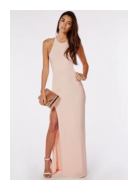

In [38]:
# display the selected images

outfit_img_id = 143719
outfits_selected = data_df_output.iloc[[outfit_img_id]] 
show_similar_images(outfits_selected, fig_size=[2,2])

In [ ]:
base_image, base_label, similar_images_df = get_similar_images_cos(outfit_img_id)

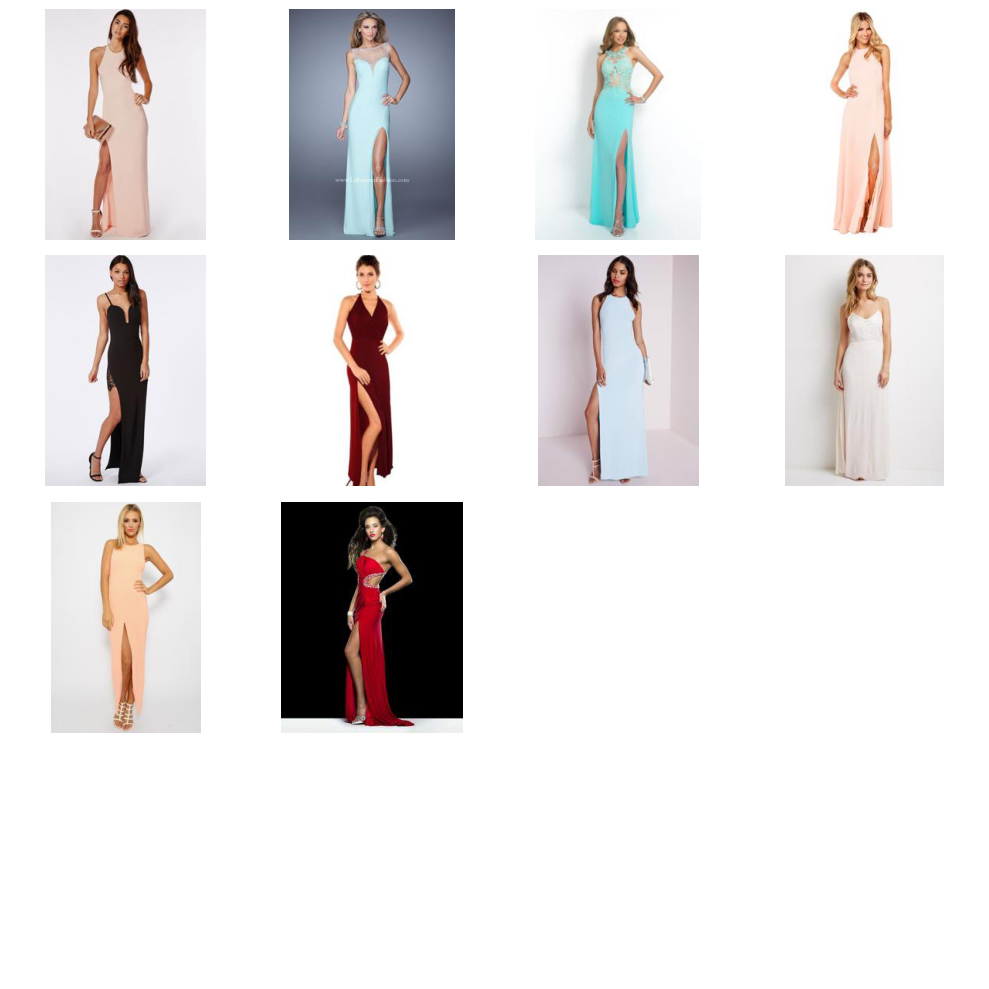

In [ ]:
# display similar images

show_similar_images(similar_images_df)

The above recommendations based on cosine similarities are very interesting as they include items that are different than the ANNOY-based recommendations. It looks like it detected that our target image had "a slit" and "no patterns." The resulting images are high slit dresses with various colors, and they are more likely to be suited for a cocktail party than a summer party. 

- A caveat to note is that our function does not take more than one images at a time as an input. Therefore, the results are based on only one image. However, these two results are still comparable because, when we used this same image as the only input to generate ANNOY-based recommendations, it recommended images that are generally similar to the one we obtained above. 


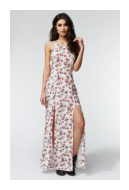

In [ ]:
outfit_img_id = 143717
outfits_selected = data_df_output.iloc[[outfit_img_id]] 
show_similar_images(outfits_selected, fig_size=[2,2])

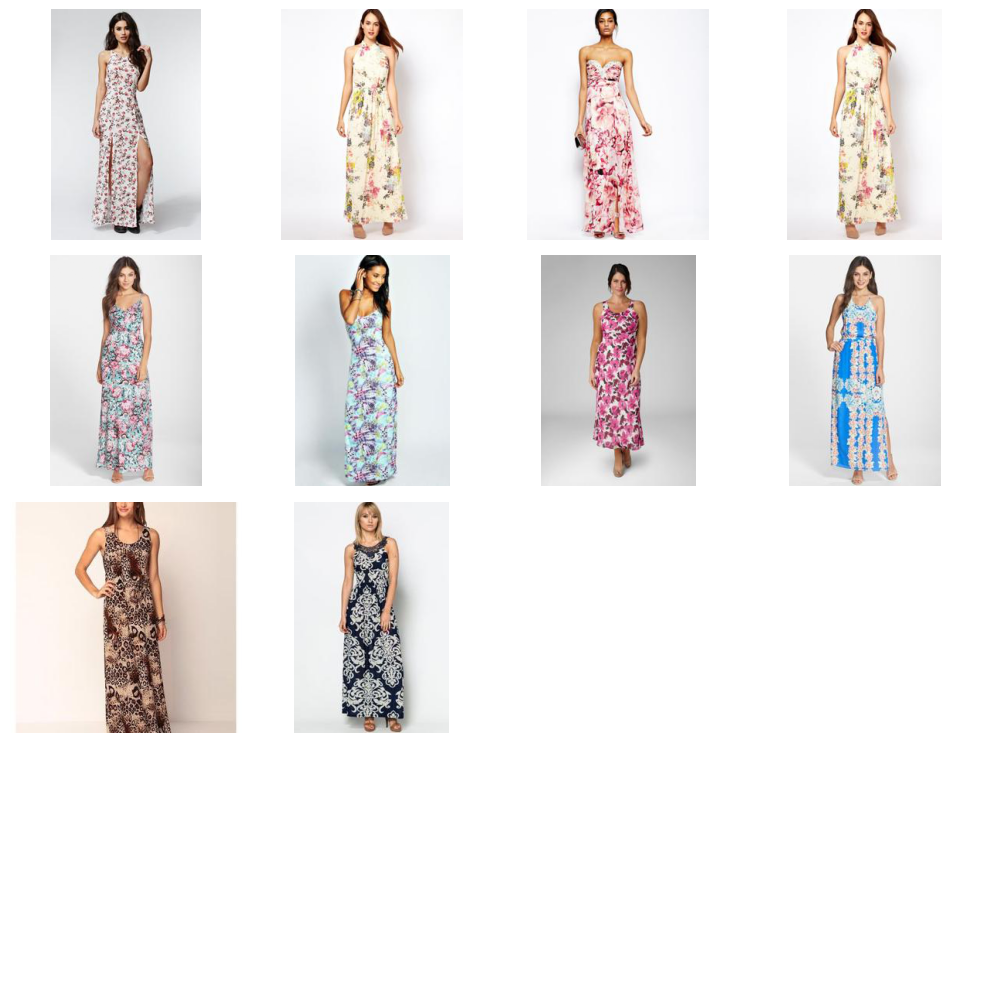

In [ ]:
base_image, base_label, similar_images_df = get_similar_images_cos(outfit_img_id)
show_similar_images(similar_images_df)

Above are another examples of cosine-based recommendations. Similar to the result above, they have wider range of colors and patterns compared to the ANNOY-based recommendations. However, this time the model did not detect that the dress had a slit, and therefore none of the resulting recommendations (besides the one itself) do not have any slits. 

#### (3) Discussion: Comparing the ANNOY and Cosine Similarity Methods (ResNet18)

- Both ANNOY and cosine similarity methods are effective in giving recommendations in two different ways. ANNOY recommends items that are very similar to the target image, while cosine method makes "bolder" recommendations with a wide range of colors and patterns. 
- Whether one method is better than another would depend on the personal preference of a consumer, or the sales tactic of a seller. If an online clothing store thinks that recommending a very similar product would increase its sales and wants to take a safer approach, an ANNOY-based recommendation system would be better. 
- In terms of processing speed, the cosine distance method took approximately 7 seconds to generate the desired results, while the ANNOY method required less than 2 milliseconds to generate the similar images. 
- Overall, both methods yielded good recommendations in two interesting ways, but the ANNOY method outperformed the cosine distance method in terms of the processing speed, making it a more efficient choice for generating similar images.

### **(B) Using ResNet50 Embeddings**

#### (1) Generate Similar Images Using ANNOY

Here we generate similar images using the same input (the four dresses we selected above) and ResNet50 embeddings. 

In [30]:
data_df_output = data_df_output2

In [123]:
# Select random dresses

outfit_img_ids = [143716, 143717, 143718, 143719]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_output.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_output.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

4.37164306640625 ms


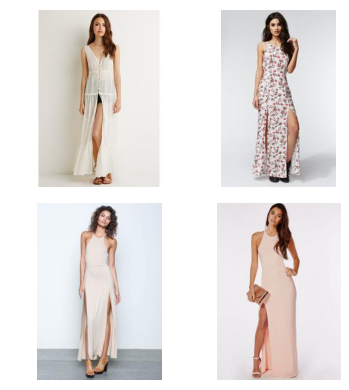

In [125]:
show_similar_images(outfits_selected, fig_size=[4,4])

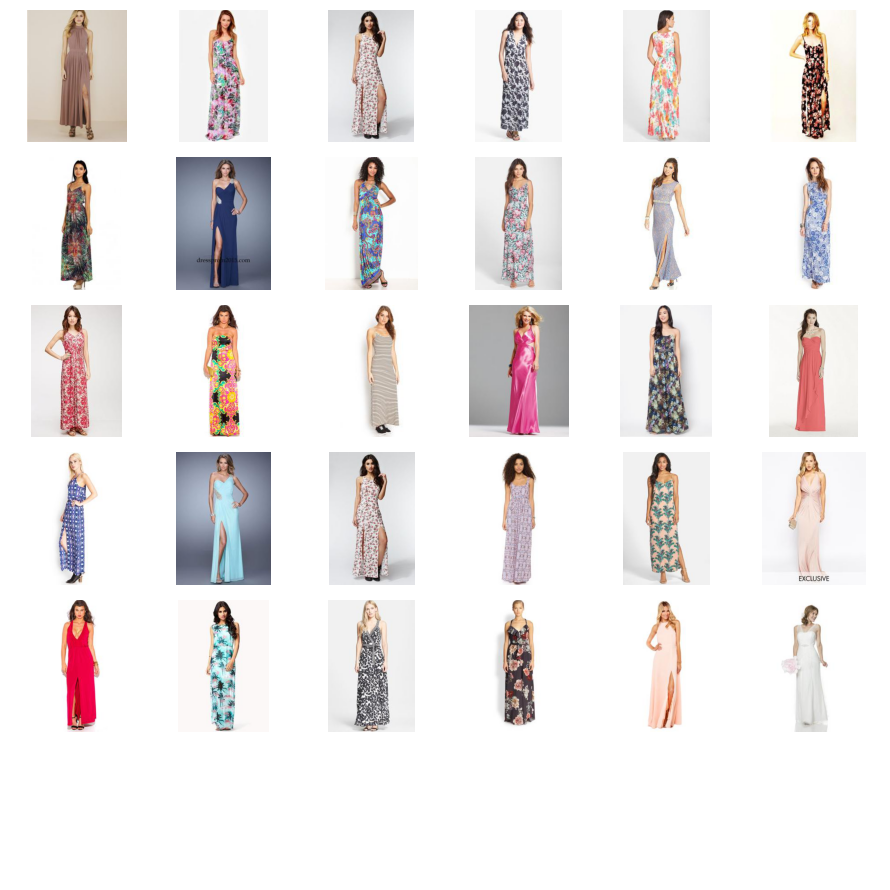

In [36]:
# Display Similar Images

show_similar_images(similar_images_df, fig_size=[9,9])

The model took the same four images of dresses I used in the ResNet18 section as inputs and generated drastically different results. The results are no longer as similar to the inputted images. They vary widely in pattern, color, and shape. Generally, they have much more colors and more playful patterns.  

ResNet50 has a deeper architecture compared to ResNet18 and is able to capture more complex and intricate patterns in the data. We believe that ResNet50 learned more sophisticated features and was able to detect the pattern in the second input image (flower pattern dress) more clearly, and the results are based on this detection. 

#### (2) Generate Similar Images Cosine Distance

In [39]:
from scipy.spatial.distance import cosine

def get_similar_images_cos(img_index, n=10):
    base_img_id, base_vector, base_label  = data_df_output.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - data_df_output['embeddings'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    return base_img_id, base_label, data_df_output.iloc[similar_img_ids]


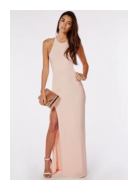

In [40]:
# display the selected images

outfit_img_id = 143719
outfits_selected = data_df_output.iloc[[outfit_img_id]] 
show_similar_images(outfits_selected, fig_size=[2,2])

In [41]:
base_image, base_label, similar_images_df = get_similar_images_cos(outfit_img_id)

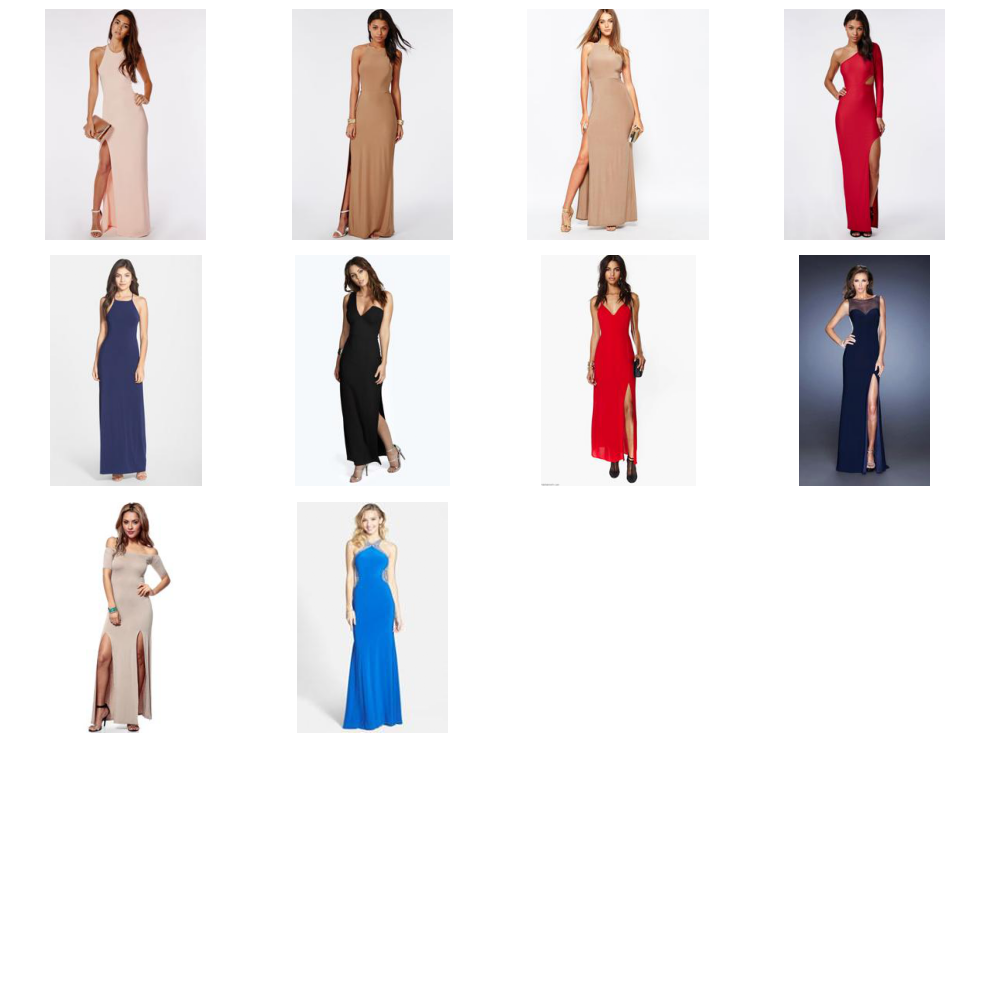

In [42]:
# display similar images

show_similar_images(similar_images_df)

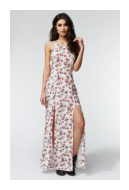

In [43]:
outfit_img_id = 143717
outfits_selected = data_df_output.iloc[[outfit_img_id]] 
show_similar_images(outfits_selected, fig_size=[2,2])

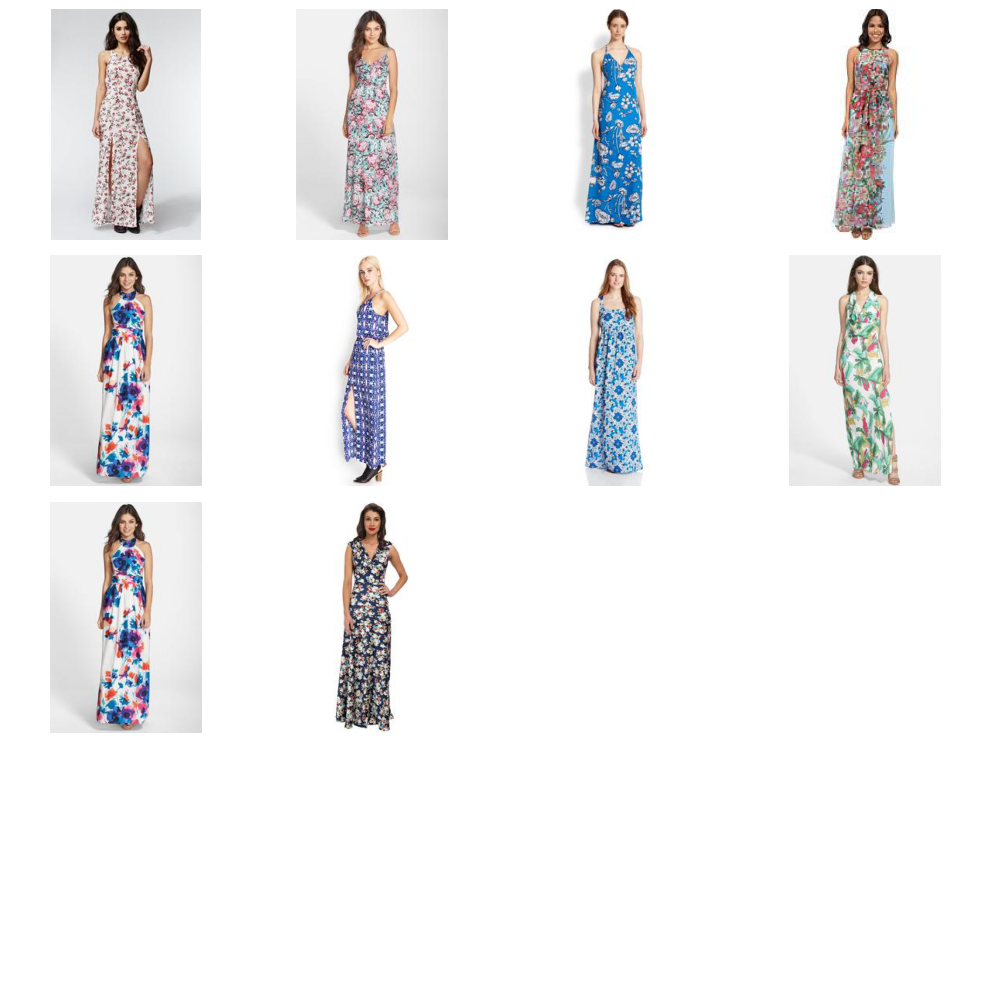

In [44]:
base_image, base_label, similar_images_df = get_similar_images_cos(outfit_img_id)
show_similar_images(similar_images_df)

The recommendations are very similar to the cosine similarity based recommendations using the ResNet18 embeddings. The cosine method using ResNet50 generated a different set of images, but the results are very similar to the one using ResNet18.

#### (3) Discussion: Comparing the ResNet50 vs ResNet18 results

- When ResNet50 embeddings were used, the results under the ANNOY and cosine similarity methods were less different, compared to the results we observed when ResNet18 was used. We presume that this is because ResNet50 was able to detect more intricate patterns. 

- Given the results we obtained, it is hard to say whether ResNet50 is a better choice if the purpose is to find similar images efficiently. The ANNOY method using the ResNet50 embeddings gave a lot of bold recommendations and it took a lot longer because training ResNet50 required more computational resources. While the choice between ResNet50 and ResNet18 depends on the specific requirement of a consumer or a seller, if the purpose is to find similar images without using significant computational power, ResNet18 is a better choice.

##**Part IV: Simulation - Provide Recommendations Based on Personal Outfit Choices**##

### **A Fictional Consumer: A Girl Going on a Summer Vacation**

For this user, we used images that already exist in our dataset. The purpose of the simulation is to see how well our model generates recommendations based on different kinds of clothing items we manually selected. Based on the result we saw above, this simulation uses ResNet18 and ANNOY to find similar images. 

In [ ]:
# selecting a t shirt, shorts, and three different kinds of dresses
yujin_list = ['./img/Baroque_Lace_Shorts/img_00000001.jpg' #
,'./img/1981_Graphic_Ringer_Tee/img_00000002.jpg' #
,'./img/Asymmetric_Printed_Wrap_Dress/img_00000001.jpg'
,'./img/Palm_Tree_Graphic_Dress/img_00000002.jpg'
,'./img/Perforated_Yoke_Shirt_Dress/img_00000002.jpg' #
] 

In [ ]:
yujin_df = data_df_output[data_df_output['img_path'].isin(yujin_list)]
yujin_df

img_path   label  label_id  \
155622  ./img/Asymmetric_Printed_Wrap_Dress/img_000000...   Dress        13   
184952  ./img/Perforated_Yoke_Shirt_Dress/img_00000002...   Dress        13   
185432     ./img/Palm_Tree_Graphic_Dress/img_00000002.jpg   Dress        13   
213749     ./img/1981_Graphic_Ringer_Tee/img_00000002.jpg     Tee        42   
231378         ./img/Baroque_Lace_Shorts/img_00000001.jpg  Shorts        36   

                                               embeddings  
155622  [-28.519302368164062, 25.93801498413086, 12.88...  
184952  [-18.318479537963867, -12.925629615783691, -17...  
185432  [-13.891491889953613, 8.892098426818848, 27.11...  
213749  [7.985297679901123, -5.158089637756348, -19.40...  
231378  [-0.34558752179145813, 0.5021840333938599, -26...

In [ ]:
outfit_img_ids = [213749, 231378, 184952, 155622, 185442]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_output.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_output.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)


5.246400833129883 ms


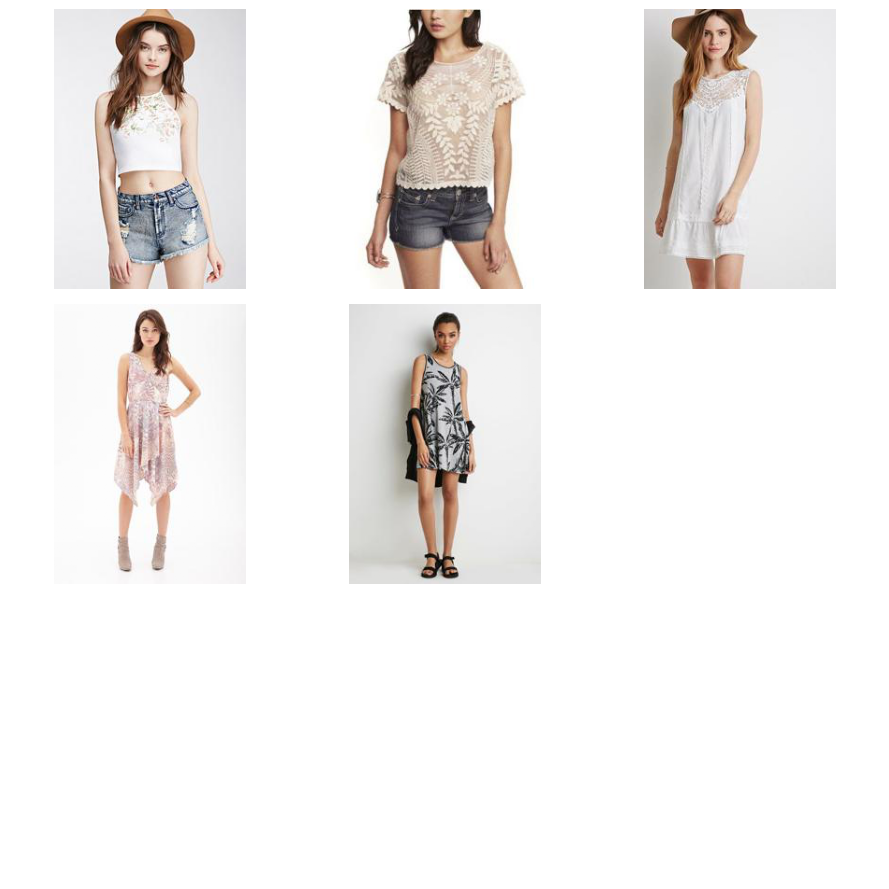

In [ ]:
show_similar_images(outfits_selected, fig_size=[9,9])

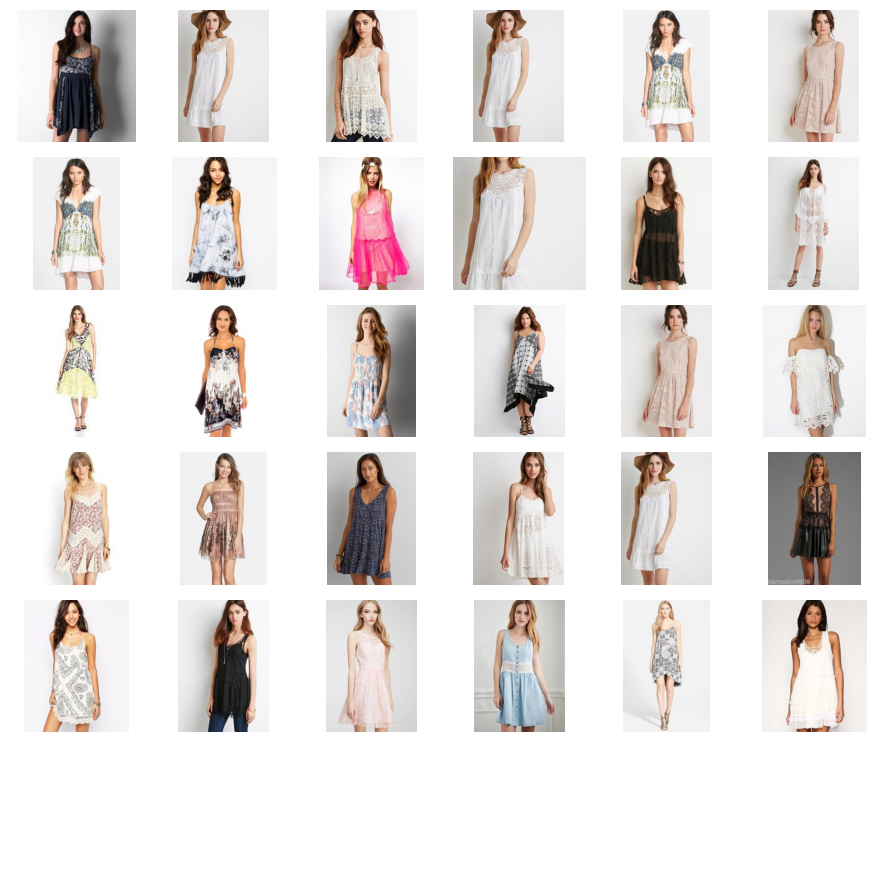

In [ ]:
show_similar_images(similar_images_df, fig_size=[9,9])

They quality of the recommendations for the dresses is quite good, as it recommends a wide variety of similar dresses with similar colors and patterns. 

However, it is surprising that the recommended items did not include any t-shirt or shorts. 



## **Part V: Conclusion**




As discussed in Part III, the main finding of our project is that ResNet18 surprisingly does a better job finding similar images that consumers may prefer. 

To further extend our analysis, it would be helpful to evaluate our models based on objective metrics using our test data, such as by measuring an extent to which the recommendations are similar or dissimilar to each other using their latent features. Our evaluation is limited to our personal opinions on whether we think the recommendations are satisfactory. 

Also, we would like to find out why our model only generates a certain category of images, such as dress, when inputted multiple category of images. This could be due to an overrepresentation of dresses in our dataset.

Also, it would be interesting to try generating recommendations using images our own clothes, or images searched online that is not in our original dataset. We tried this step, but unfortunately due to time constraints we were not able to perform it. Below are the kind of images we wanted to try getting recommendations on.

In [130]:
url = 'https://drive.google.com/uc?id=1h_qGu-S-Cm5dX7YQChaP8LAXmFMdtNEd'

output = 'persona3.zip'
gdown.download(url, output)
with zipfile.ZipFile("persona3.zip","r") as zip_ref:
    zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=1h_qGu-S-Cm5dX7YQChaP8LAXmFMdtNEd
To: /content/persona3.zip
100%|██████████| 1.46M/1.46M [00:00<00:00, 183MB/s]


In [131]:
def get_persona_images(photo_dir):

 # Get a list of all the photo filenames in the directory
  photo_filenames = os.listdir(photo_dir)
 # Set the number of photos to display
  num_photos = 5
 # Display the photos
  fig, ax = plt.subplots(1, num_photos, figsize=(20, 20))
  for i in range(num_photos):
        # Load the photo from file
    img = plt.imread(os.path.join(photo_dir, photo_filenames[i]))
         # Display the photo
    ax[i].imshow(img)
    ax[i].axis('off')

  # Show the plot
  plt.show()

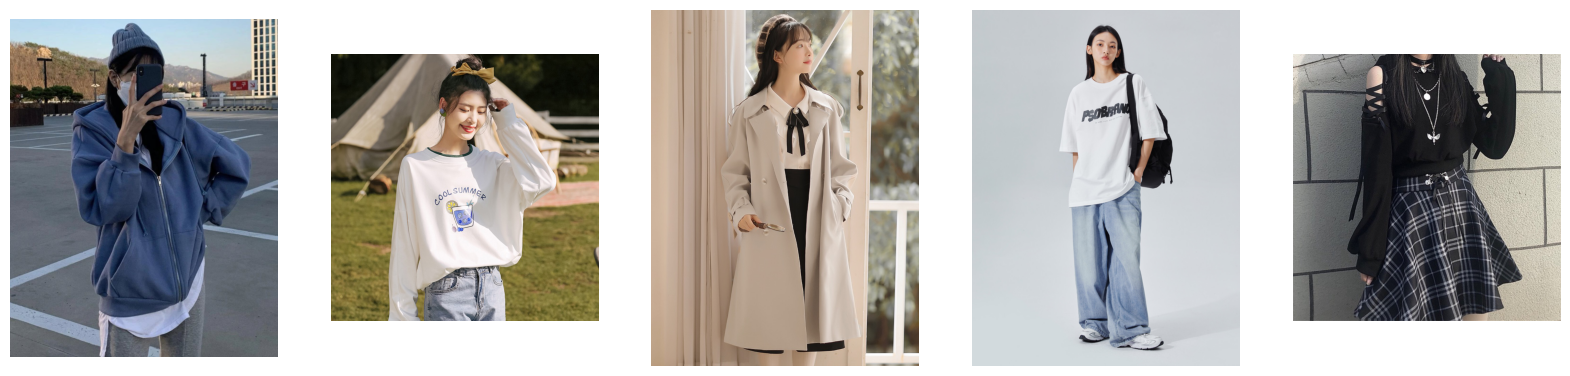

In [132]:
get_persona_images('3')